In [28]:
"""
The Full Whiskas Model Python Formulation for the PuLP Modeller

Authors: Ahmed Elsherif for learning purposes
"""

# Import PuLP modeler functions
import pulp
import pandas as pd

In [29]:
# load ingredient data
df_indredients = pd.read_csv("data/ingredients.csv", index_col="ingredient")

# load nutritional constraints
df_constraints = pd.read_csv("data/constraints.csv", index_col="nutrient")

In [30]:
df_indredients

,cost,protein,fat,fibre,salt
ingredient,,,,,
chicken,0.013,0.10,0.08,0.001,0.002
beef,0.008,0.20,0.10,0.005,0.005
mutton,0.010,0.15,0.11,0.003,0.007
rice,0.002,0.00,0.01,0.100,0.002
wheat,0.005,0.04,0.01,0.150,0.008
gel,0.001,0.00,0.00,0.000,0.000


In [31]:
df_constraints

,min,max
nutrient,,
protein,8.0,NaN
fat,6.0,NaN
fibre,NaN,2.0
salt,NaN,0.4


In [32]:
# Creates a list of the Ingredients
Ingredients = df_indredients.index.tolist()

# A dictionary of the costs of each of the Ingredients is created
costs = df_indredients["cost"].to_dict()

# Nutrient content per ingredient
nutrients = {
    nutrient: df_indredients[nutrient].to_dict()
    for nutrient in df_constraints.index
}

# define bounds
min_req = df_constraints["min"].fillna(0).to_dict()
max_req = df_constraints["max"].fillna(float("inf")).to_dict()

In [33]:
# Create the 'prob' variable to contain the problem data
model = pulp.LpProblem("The_Whiskas_Problem", pulp.LpMinimize)

In [34]:
# decision variables
x = pulp.LpVariable.dicts("Percent", Ingredients, lowBound=0)

In [35]:
# objective function: minimize cost
model += pulp.lpSum(costs[i] * x[i] for i in Ingredients)

In [36]:
# constraints: sum of ingredients = 100
model += pulp.lpSum(x[i] for i in Ingredients) == 100

In [37]:
# constraints: nutrition value requirements
for j in nutrients:
    # lower bound
    model += pulp.lpSum(nutrients[j][i] * x[i] for i in Ingredients) >= min_req[j], f"{j}_min"
    # upper bound
    if max_req[j] < float("inf"):
        model += pulp.lpSum(nutrients[j][i] * x[i] for i in Ingredients) <= max_req[j], f"{j}_max"

In [ ]:
# solve the model
model.solve()

1

In [41]:
# Output
print(f"Status: {pulp.LpStatus[model.status]}")
print(f"Total cost per can: ${pulp.value(model.objective):.4f}")
for i in Ingredients:
    print(f"{i}: {x[i].varValue:.2f}g")

Status: Optimal
Total cost per can: $0.5200
chicken: 0.00g
beef: 60.00g
mutton: 0.00g
rice: 0.00g
wheat: 0.00g
gel: 40.00g


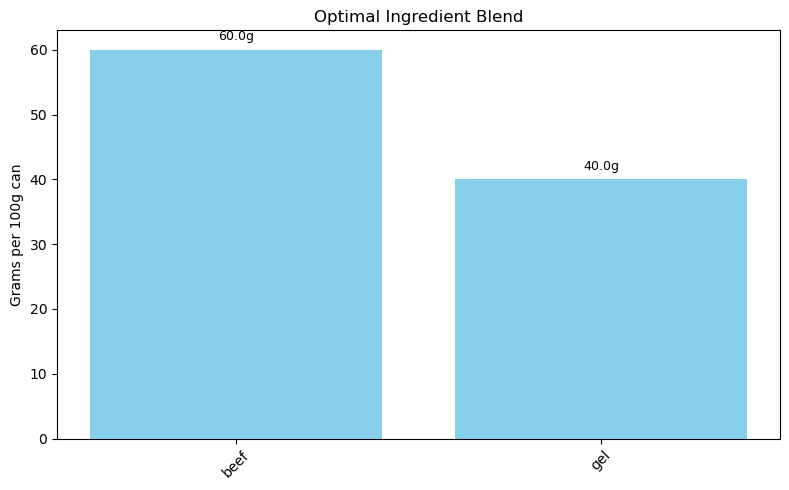

In [49]:
import matplotlib.pyplot as plt

# Solve model if not already done
model.solve()

# Extract non-zero solution values
solution = {i: x[i].varValue for i in Ingredients if x[i].varValue > 0}
labels = list(solution.keys())
values = list(solution.values())

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color="skyblue")

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f"{yval:.1f}g",
             ha='center', va='bottom', fontsize=9)

plt.ylabel("Grams per 100g can")
plt.title("Optimal Ingredient Blend")
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig("results/solution_plot.png")
plt.show()


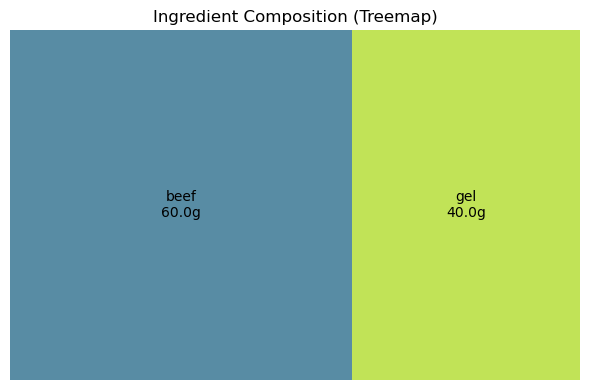

In [50]:
import matplotlib.pyplot as plt
import squarify

# Treemap plot
plt.figure(figsize=(6, 4))
sizes = list(solution.values())
labels_with_values = [f"{k}\n{v:.1f}g" for k, v in solution.items()]

squarify.plot(sizes=sizes, label=labels_with_values, alpha=0.8, text_kwargs={'fontsize': 10})
plt.title("Ingredient Composition (Treemap)")
plt.axis('off')
plt.tight_layout()
plt.savefig("results/solution_treemap.png")
plt.show()
